# Проект: классификация

In [1]:
#загрузка необходимых модулей 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [2]:
# загрузка датасета

df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
#ознакомление с данными
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [5]:
# исследование данных на предмет пропусков

null_data = df.isnull().sum()

print(f'\nСтолбцы с пропусками данных:\n{null_data[null_data > 0]}')


Столбцы с пропусками данных:
balance    25
dtype: int64


In [6]:
# исследование в признаке job пропущенных значений

df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

Пропуски обозначены как 'unknow'

In [7]:
# преобразование признака balance таким образом, чтобы он корректно считывался, как вещественное число (float)

In [8]:
ds = df.copy()

In [9]:
#замена символов в строках
ds['balance'] = ds['balance'].str.replace('$', '', regex=True)
ds['balance'] = ds['balance'].str.replace(' ', '', regex=True)
ds['balance'] = ds['balance'].str.replace(',00', '', regex=True)

In [10]:
#преобразование строки в вещественное число
ds['balance'] = ds['balance'].astype(dtype='float')

In [11]:
ds['balance'].mean()

1529.1290293615875

In [12]:
# обработка пропусков в признаке balance и замена их на медианные значения по данному признаку

In [13]:
ds['balance'].describe()

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

In [14]:
ds['balance'] = ds['balance'].fillna(ds['balance'].median())

In [15]:
ds['balance'].mean()

1526.9360329690019

In [16]:
# обработка пропусков в категориальных признаках: job и education и замена их на модальные значения

In [17]:
ds['job'].mode() 

0    management
Name: job, dtype: object

In [18]:
ds['education'].mode()

0    secondary
Name: education, dtype: object

In [19]:
# замена пропусков на модальные значения
ds['job'] = ds['job'].replace('unknown', 'management')
ds['education'] = ds['education'].replace('unknown', 'secondary')

In [20]:
ds[(ds['job'] == 'management') & (ds['education'] == 'secondary')]['balance'].mean()

1598.8829787234042

In [21]:
# IQR определение границ выброса для параметра balance
q1 = np.percentile(ds['balance'], 25,
                   interpolation = 'midpoint')
 
q3 = np.percentile(ds['balance'], 75,
                   interpolation = 'midpoint')
iqr = q3 - q1

q1_iqr = q1 - 1.5 * iqr
q3_iqr = q3 + 1.5 * iqr

In [22]:
print(f'\nнижняя граница:\n{q1_iqr}')
print(f'\nверхняя граница:\n{q3_iqr}')


нижняя граница:
-2241.0

верхняя граница:
4063.0


In [23]:
# удаление всех выбросов для признака balance

In [24]:
#скопируем датасет 
ds_1 = ds.copy()

In [25]:
#создание условия для удаления выбросов и удаление выбросов по верхней и нижней границам
ds_1 = ds_1[ds_1.balance >= -2241.0]
ds_1 = ds_1[ds_1.balance <= 4063.0]

In [26]:
ds_1['balance'].describe()

count    10105.000000
mean       807.653538
std        994.151966
min      -2049.000000
25%         95.000000
50%        445.000000
75%       1227.000000
max       4063.000000
Name: balance, dtype: float64

## Часть 2:  Разведывательный анализ

In [27]:
#библиотеки для визуализации
import matplotlib.pyplot as plt  
import seaborn as sns  
import plotly.express as px

In [28]:
# изучение соотношения классов в данных на предмет несбалансированности 

In [29]:
ds_1['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

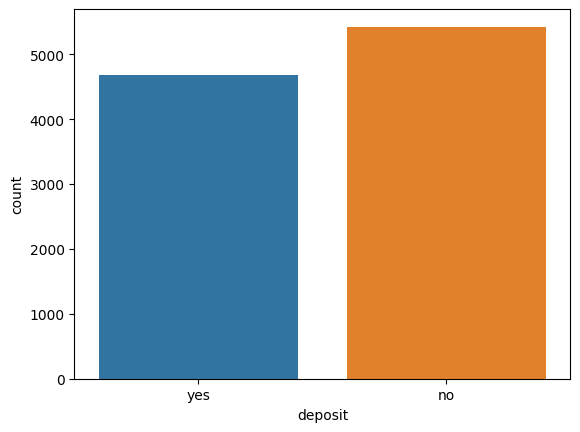

In [30]:
#визуализируем соотношение классов в переменной deposit
display(ds_1['deposit'].value_counts(normalize=True))
sns.countplot(data=ds_1, x='deposit');

Можносказать, что классы сбалансирован.

In [31]:
#рассчет описательной статистики для количественных переменных

In [32]:
print('Максимальный возраст клиента:', ds_1['age'].max()), \
print('Mинимальная продолжительность разговора с клиентом банка:', ds_1['duration'].min())

Максимальный возраст клиента: 95
Mинимальная продолжительность разговора с клиентом банка: 2


(None, None)

#### оценим влияние количественных переменных на депозит

In [33]:
#оценим влияние количественных переменных на депозит
ds_1.groupby('deposit').mean()

,age,balance,day,duration,campaign,pdays,previous
deposit,,,,,,,
no,40.629978,682.155420,16.036320,221.316740,2.845870,36.253872,0.522124
yes,41.203162,953.071566,15.073489,539.568896,2.136296,68.776757,1.157018


<Figure size 640x480 with 0 Axes>

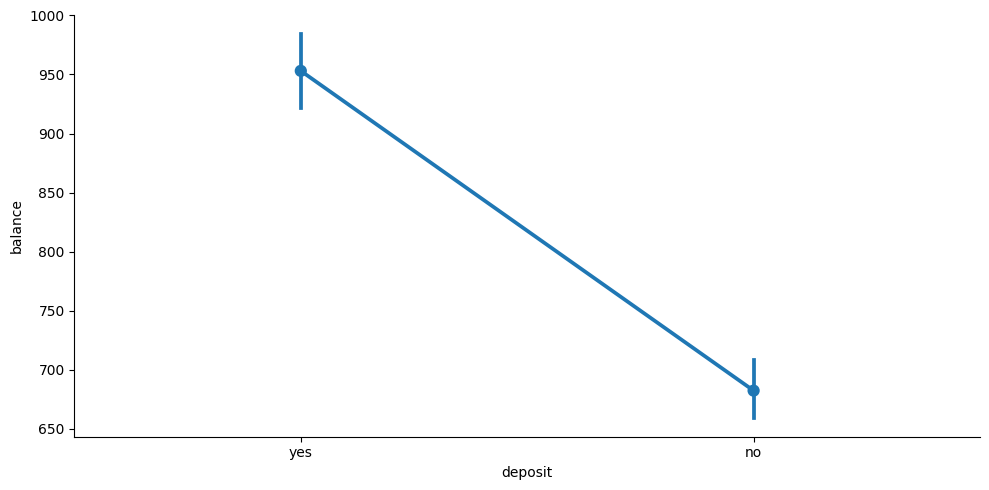

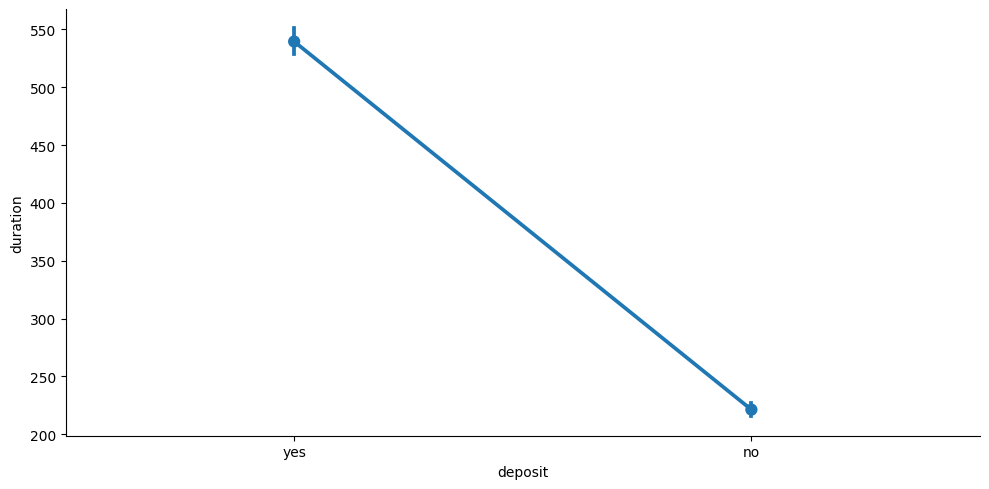

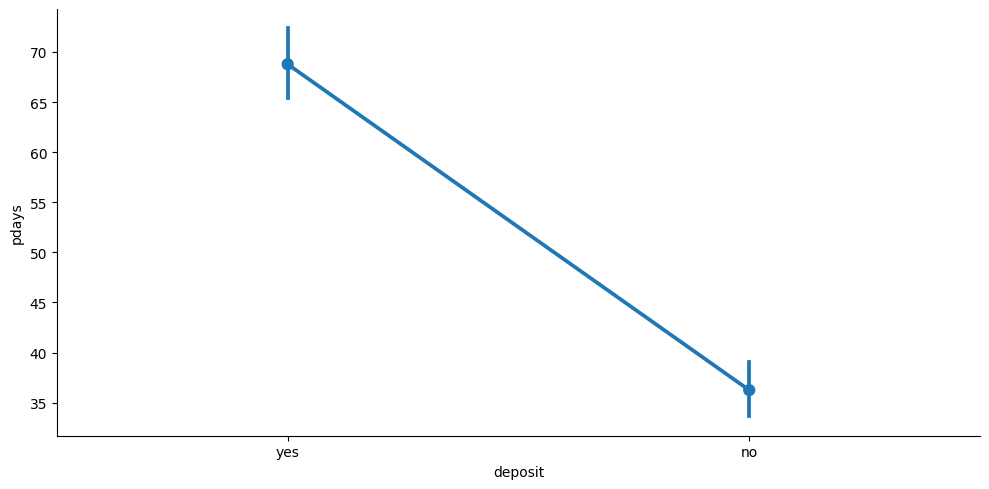

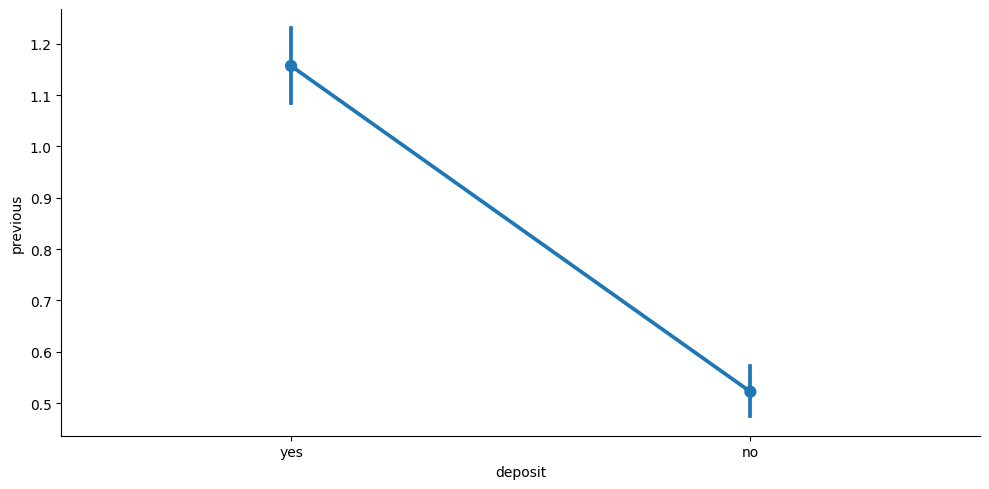

In [34]:
# построим график для наиболее выраженных зависимостей факторов на депозит
for i, col in enumerate(['balance', 'duration', 'pdays', 'previous']):
    plt.figure(i)
    sns.catplot(y=col, x='deposit', data=ds_1, kind='point', aspect=2)

<AxesSubplot:xlabel='deposit', ylabel='balance'>

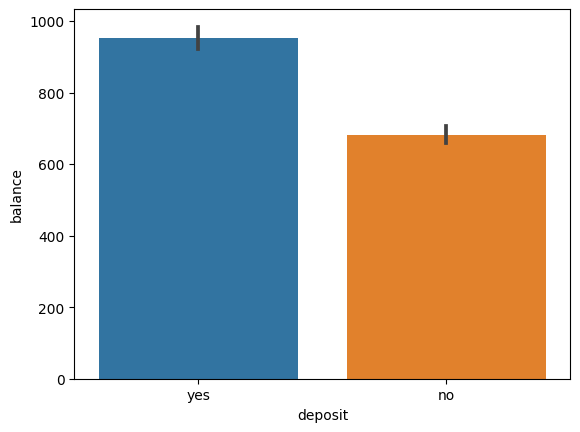

In [35]:
#оценим влияние баланса на налицие депозита
sns.barplot(x='deposit', y='balance', data=ds_1)

Количество клиентов, имеющих депозит, обладают большим балансом. Логично предположить, что это позволяет легче делать накопления и формировать депозит.
Соответственно, зависимость наличия депозита от большего баланса прямопропорциональная. Оценим зависимость баланса от различных факторов.

#### Посмотрим зависимость баланса от различных факторов.

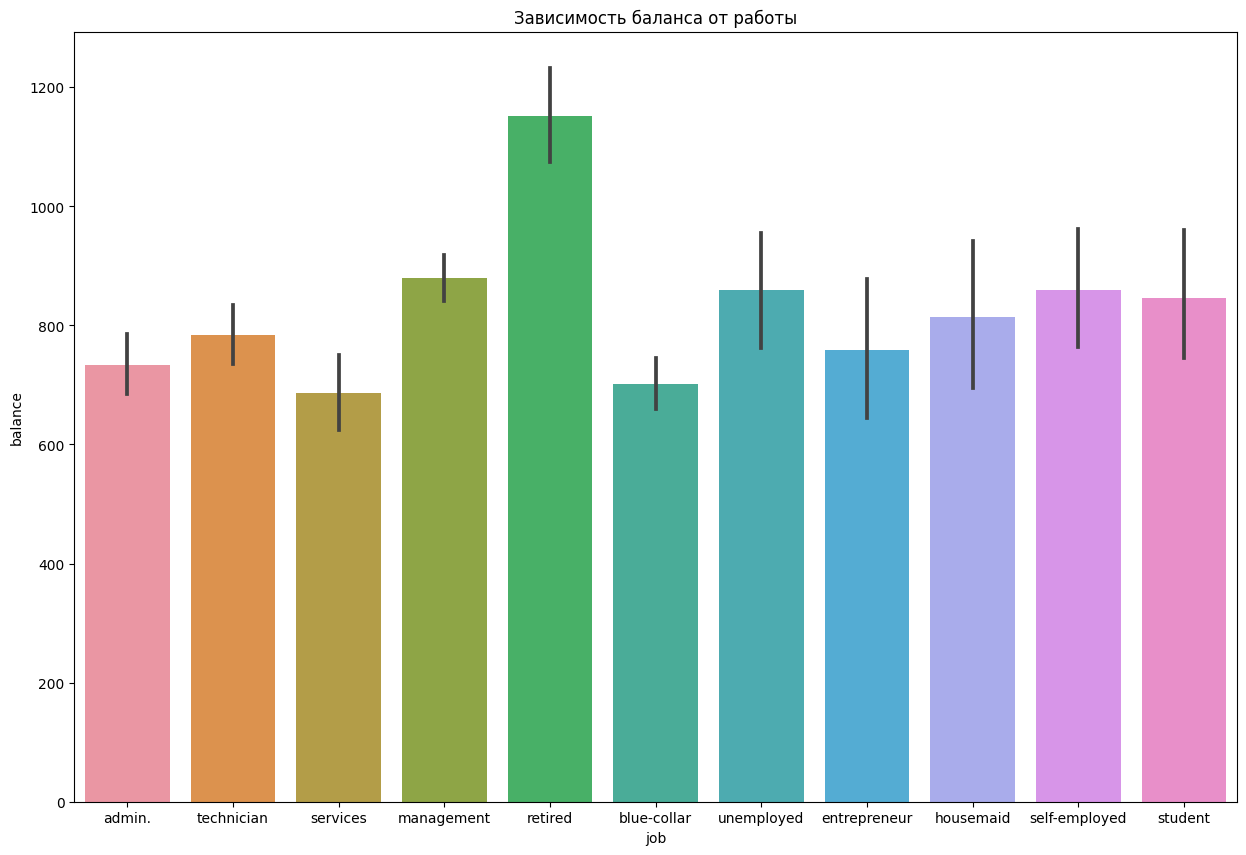

In [36]:
#оценка влияния работы на баланс клиента
fig = plt.figure(figsize=(15, 10))
barplot = sns.barplot(
    data = ds_1,
    x = 'job',
    y = 'balance'
)
barplot.set_title('Зависимость баланса от работы');

Баланс зависит от вида работы. Наибольший баланс у пенсионеров, наименьший у работников в сфере услуг.

In [37]:
data = ds_1[ds_1['deposit'] == 'yes']

In [38]:
#оценка связи баланса с работой и образованием
data = data.pivot_table('balance', index ='job', columns='education', aggfunc='mean')
data

education,primary,secondary,tertiary
job,,,
admin.,643.000000,867.162791,829.370787
blue-collar,749.020305,809.326389,670.782609
entrepreneur,563.500000,951.288462,954.040816
housemaid,1157.586957,898.529412,1168.263158
management,1053.421053,1142.834437,1033.756477
retired,1347.400000,1163.201031,1414.443182
self-employed,457.000000,712.609756,1102.758621
services,852.703704,768.538721,787.952381
student,885.857143,810.346154,996.000000


In [39]:
px.scatter(data, color='education')

Данный график показывает, что не во всех сферах деятельности прямая прямопорциональная зависимость баланса от уровня образования.

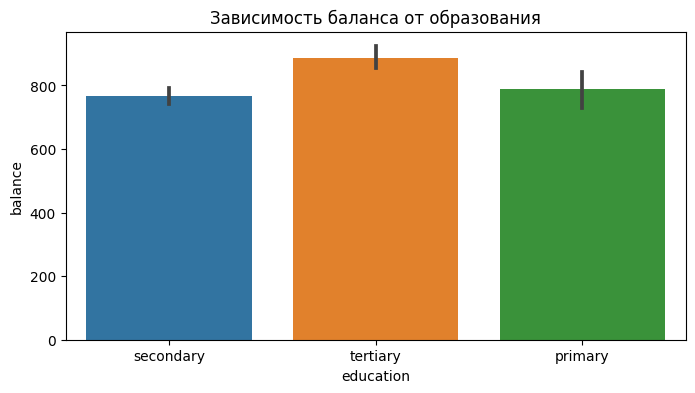

In [40]:
#оценка влияния образования на баланс клиента
fig = plt.figure(figsize=(8, 4))
barplot = sns.barplot(
    data = ds_1,
    x = 'education',
    y = 'balance'
)
barplot.set_title('Зависимость баланса от образования');

Влияние образование на баланс также наблюдается, клиенты с высшим образованием имеют больший баланс.
Также интересная тенденция, что у клиентов с средним образованием баланс ниже, чем у тех, кто имеет начальное образование.

In [41]:
#рассчет описательной статистики для категориальных переменных

In [42]:
ds_1['contact'].describe()

count        10105
unique           3
top       cellular
freq          7283
Name: contact, dtype: object

cellular     0.720732
unknown      0.213855
telephone    0.065413
Name: contact, dtype: float64

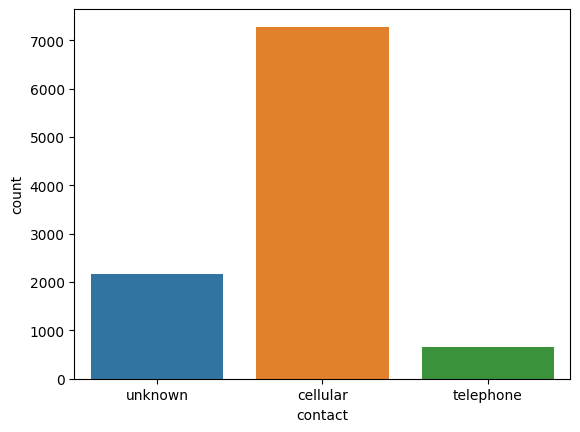

In [43]:
display(ds_1['contact'].value_counts(normalize=True))
sns.countplot(data=ds_1, x='contact');

In [44]:
ds_1['month'].describe()

count     10105
unique       12
top         may
freq       2617
Name: month, dtype: object

In [45]:
# Оценка для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
ds_1['poutcome'].value_counts()

unknown    7570
failure    1109
success     945
other       481
Name: poutcome, dtype: int64

unknown    0.749134
failure    0.109748
success    0.093518
other      0.047600
Name: poutcome, dtype: float64

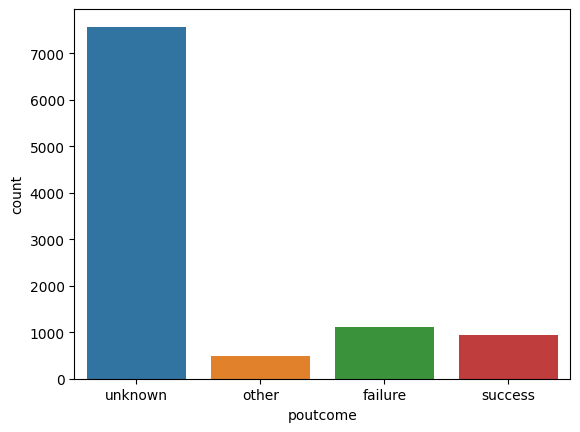

In [46]:
#визуализируем распределение результатов маркетинговой компании
display(ds_1['poutcome'].value_counts(normalize=True))
sns.countplot(data=ds_1, x='poutcome');

In [47]:
# оценка в каком месяце чаще всего отказывались от предложения открыть депозит

data = ds_1[ds_1['poutcome'] == 'failure']

data = data.pivot_table('deposit', index ='month', columns='poutcome', aggfunc='count')
data

poutcome,failure
month,
apr,150
aug,84
dec,11
feb,127
jan,39
jul,42
jun,48
mar,26
may,335


В мае наибольшее количество неудач

In [48]:
# создание возрастных групп для определения, в каких группах более склонны открывать депозит, чем отказываться от предложения

In [49]:
ds_1['age'][ds_1['age'] <30] = 29
ds_1['age'][(ds_1['age'] >= 30) & (ds_1['age'] <= 40)] = 35
ds_1['age'][(ds_1['age'] >= 30) & (ds_1['age'] < 40)] = 35
ds_1['age'][(ds_1['age'] >= 40) & (ds_1['age'] < 50)] = 45
ds_1['age'][(ds_1['age'] >= 50) & (ds_1['age'] < 60)] = 55
ds_1['age'][ds_1['age'] >= 60] = 65

In [50]:
ds_1['age'].value_counts()

35    4257
45    2086
55    1654
29    1455
65     653
Name: age, dtype: int64

yes    0.591753
no     0.408247
Name: deposit, dtype: float64

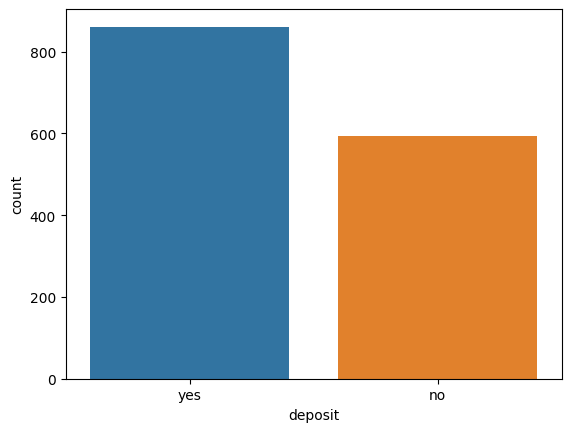

In [51]:
#оценка влияние возрастной группы на наличие депозита
data_30 = ds_1[ds_1['age'] == 29]

display(data_30['deposit'].value_counts(normalize=True))
sns.countplot(data=data_30, x='deposit');

no     0.573174
yes    0.426826
Name: deposit, dtype: float64

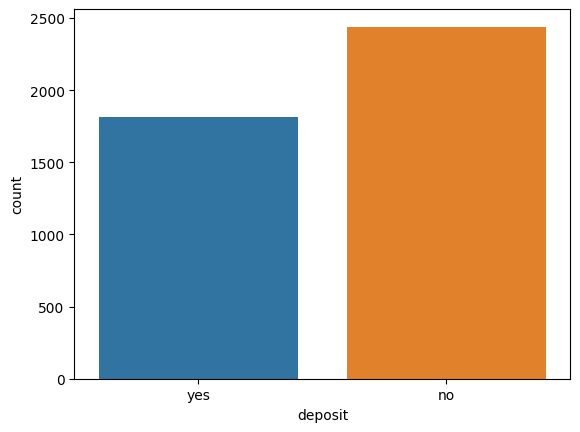

In [52]:
#оценка влияние возрастной группы на наличие депозита
data_40 = ds_1[ds_1['age'] == 35]

display(data_40['deposit'].value_counts(normalize=True))
sns.countplot(data=data_40, x='deposit');

no     0.598754
yes    0.401246
Name: deposit, dtype: float64

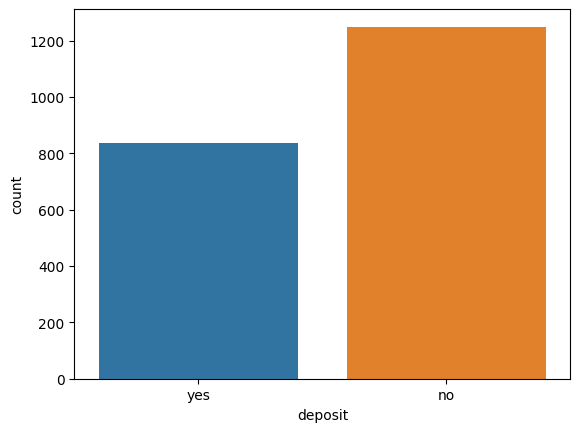

In [53]:
#оценка влияние возрастной группы на наличие депозита
data_50 = ds_1[ds_1['age'] == 45]

display(data_50['deposit'].value_counts(normalize=True))
sns.countplot(data=data_50, x='deposit');

no     0.594921
yes    0.405079
Name: deposit, dtype: float64

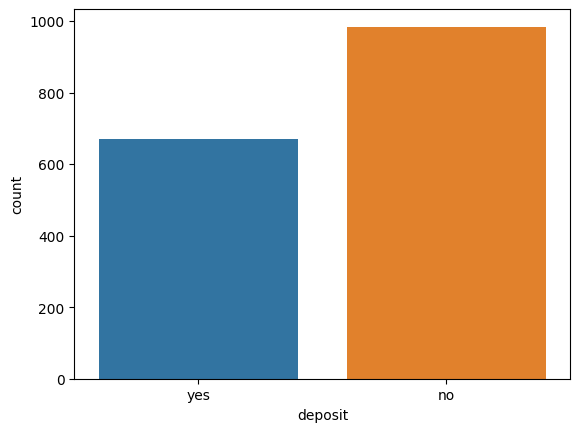

In [54]:
#оценка влияние возрастной группы на наличие депозита
data_60 = ds_1[ds_1['age'] ==55]

display(data_60['deposit'].value_counts(normalize=True))
sns.countplot(data=data_60, x='deposit');

yes    0.759571
no     0.240429
Name: deposit, dtype: float64

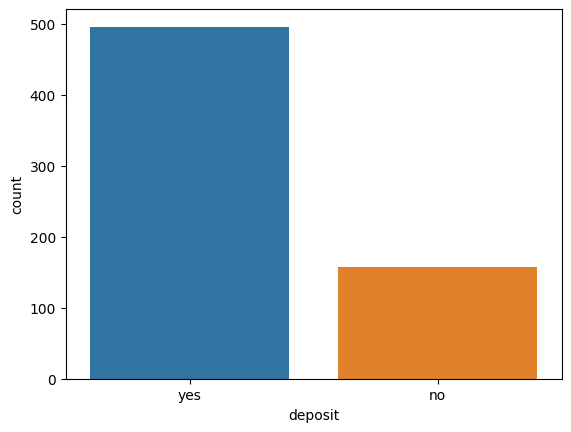

In [55]:
#оценка влияние возрастной группы на наличие депозита
data_over_60 = ds_1[ds_1['age'] == 65]

display(data_over_60['deposit'].value_counts(normalize=True))
sns.countplot(data=data_over_60, x='deposit');

In [56]:
# визуализация для открывших и неоткрывших депозит в зависимости от семейного статуса

In [57]:
data = ds_1.pivot_table('balance', index ='marital', columns='deposit', aggfunc='count')
data

deposit,no,yes
marital,,
divorced,624,553
married,3303,2412
single,1497,1716


<AxesSubplot:xlabel='marital'>

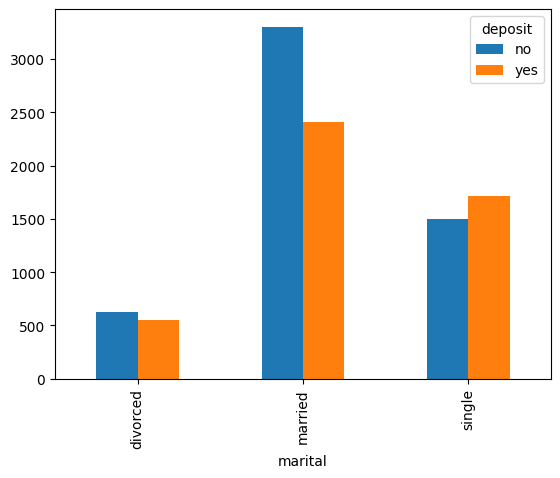

In [58]:
data.plot(kind='bar')

In [59]:
# визуализация для открывших и неоткрывших депозит в зависимости от образования
data = ds_1.pivot_table('balance', index ='education', columns='deposit', aggfunc='count')
data

deposit,no,yes
education,,
primary,832,517
secondary,3066,2451
tertiary,1526,1713


<AxesSubplot:xlabel='education'>

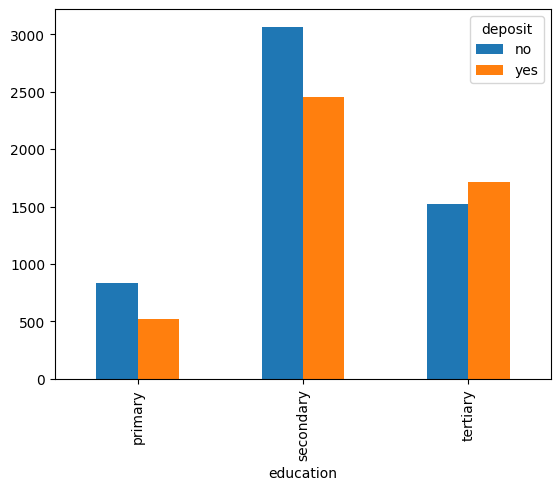

In [60]:
data.plot(kind='bar')

In [61]:
# визуализация для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

In [62]:
data = ds_1.pivot_table('balance', index ='job', columns='deposit', aggfunc='count')
data

deposit,no,yes
job,,
admin.,672,574
blue-collar,1155,652
entrepreneur,189,111
housemaid,153,99
management,1180,1135
retired,231,432
self-employed,197,161
services,523,345
student,81,245


<AxesSubplot:xlabel='job'>

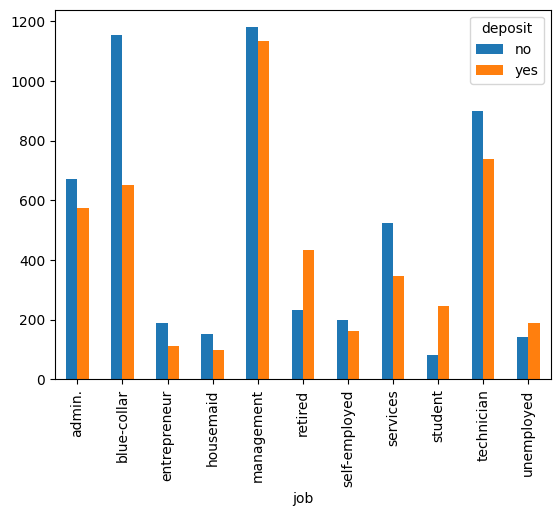

In [63]:
data.plot(kind='bar')

In [64]:
ds_1['job'].value_counts()

management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64

In [65]:
# сводная таблица, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

In [66]:
data = ds_1[ds_1['deposit'] == 'yes']
data = data.pivot_table('deposit', index='education', columns='marital', aggfunc='count')
data

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


<AxesSubplot:xlabel='marital', ylabel='education'>

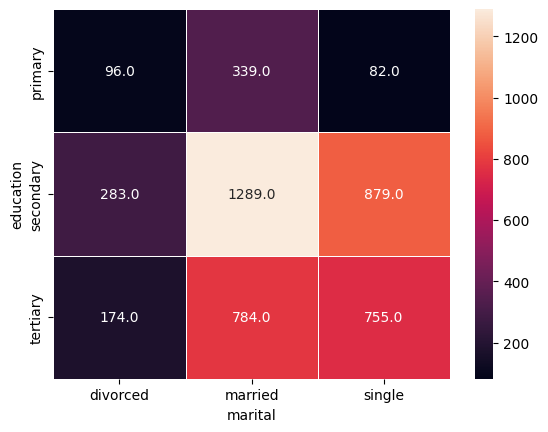

In [67]:
sns.heatmap(data, annot=True, linewidths=.5, fmt=".1f")

## Часть 3: преобразование данных

In [68]:
ds_2 = ds_1.copy()

In [69]:
# преобразование уровней образования

LE = LabelEncoder()
ds_2['education'] = LE.fit_transform(ds_2['education'])
ds_2['education'].sum()

11995

In [70]:
# преобразование возрастных групп

LE = LabelEncoder()
ds_2['age'] = LE.fit_transform(ds_2['age'])
ds_2['age'].head()

0    3
1    3
2    2
3    3
4    3
Name: age, dtype: int64

In [71]:
# преобразование бинарных переменных в представление из нулей и единиц

In [72]:
#замена бинарных признаков на 0 и 1

ds_2['deposit'] = ds_2['deposit'].replace('yes', 1)
ds_2['deposit'] = ds_2['deposit'].replace('no', 0)

ds_2['default'] = ds_2['default'].replace('yes', 1)
ds_2['default'] = ds_2['default'].replace('no', 0)

ds_2['housing'] = ds_2['housing'].replace('yes', 1)
ds_2['housing'] = ds_2['housing'].replace('no', 0)

ds_2['loan'] = ds_2['loan'].replace('yes', 1)
ds_2['loan'] = ds_2['loan'].replace('no', 0)

In [73]:
ds_2['deposit'].std()

0.4986712532452124

In [74]:
ds_2['default'].mean() + ds_2['housing'].mean() + ds_2['loan'].mean()

0.6354280059376547

In [75]:
ds_2.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,3,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1
1,3,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1
2,2,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1
3,3,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1
4,3,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1


In [76]:
# создание дамми-переменных

In [77]:
# преобразование категориальных признаков
ds_3 = pd.get_dummies(ds_2[['marital', 'job', 'contact', 'poutcome', 'month']])

ds_4 = pd.concat([ds_2, ds_3], axis=1)

In [78]:
ds_4.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,3,admin.,married,1,0,2343.0,1,0,unknown,5,...,0,0,0,0,0,0,1,0,0,0
1,3,admin.,married,1,0,45.0,0,0,unknown,5,...,0,0,0,0,0,0,1,0,0,0
2,2,technician,married,1,0,1270.0,1,0,unknown,5,...,0,0,0,0,0,0,1,0,0,0
3,3,services,married,1,0,2476.0,1,0,unknown,5,...,0,0,0,0,0,0,1,0,0,0
4,3,admin.,married,2,0,184.0,0,0,unknown,5,...,0,0,0,0,0,0,1,0,0,0


In [79]:
#удалим номинальные столбцы из датафрейма
ds_5 = ds_4.copy()
ds_5 = ds_5.drop(['marital', 'job', 'contact', 'poutcome', 'month'], axis=1)
ds_5

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,3,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,0,0,0,0,1,0,0,0
1,3,1,0,45.0,0,0,5,1467,1,-1,...,0,0,0,0,0,0,1,0,0,0
2,2,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,0,0,0,0,1,0,0,0
3,3,1,0,2476.0,1,0,5,579,1,-1,...,0,0,0,0,0,0,1,0,0,0
4,3,2,0,184.0,0,0,5,673,2,-1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,1,0,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,0,0,0,0,0
11158,1,1,0,733.0,0,0,16,83,4,-1,...,0,0,0,0,1,0,0,0,0,0
11159,1,1,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,0,0,0,0,0
11160,2,1,0,0.0,0,1,8,9,2,172,...,0,0,0,0,0,0,1,0,0,0


<AxesSubplot:>

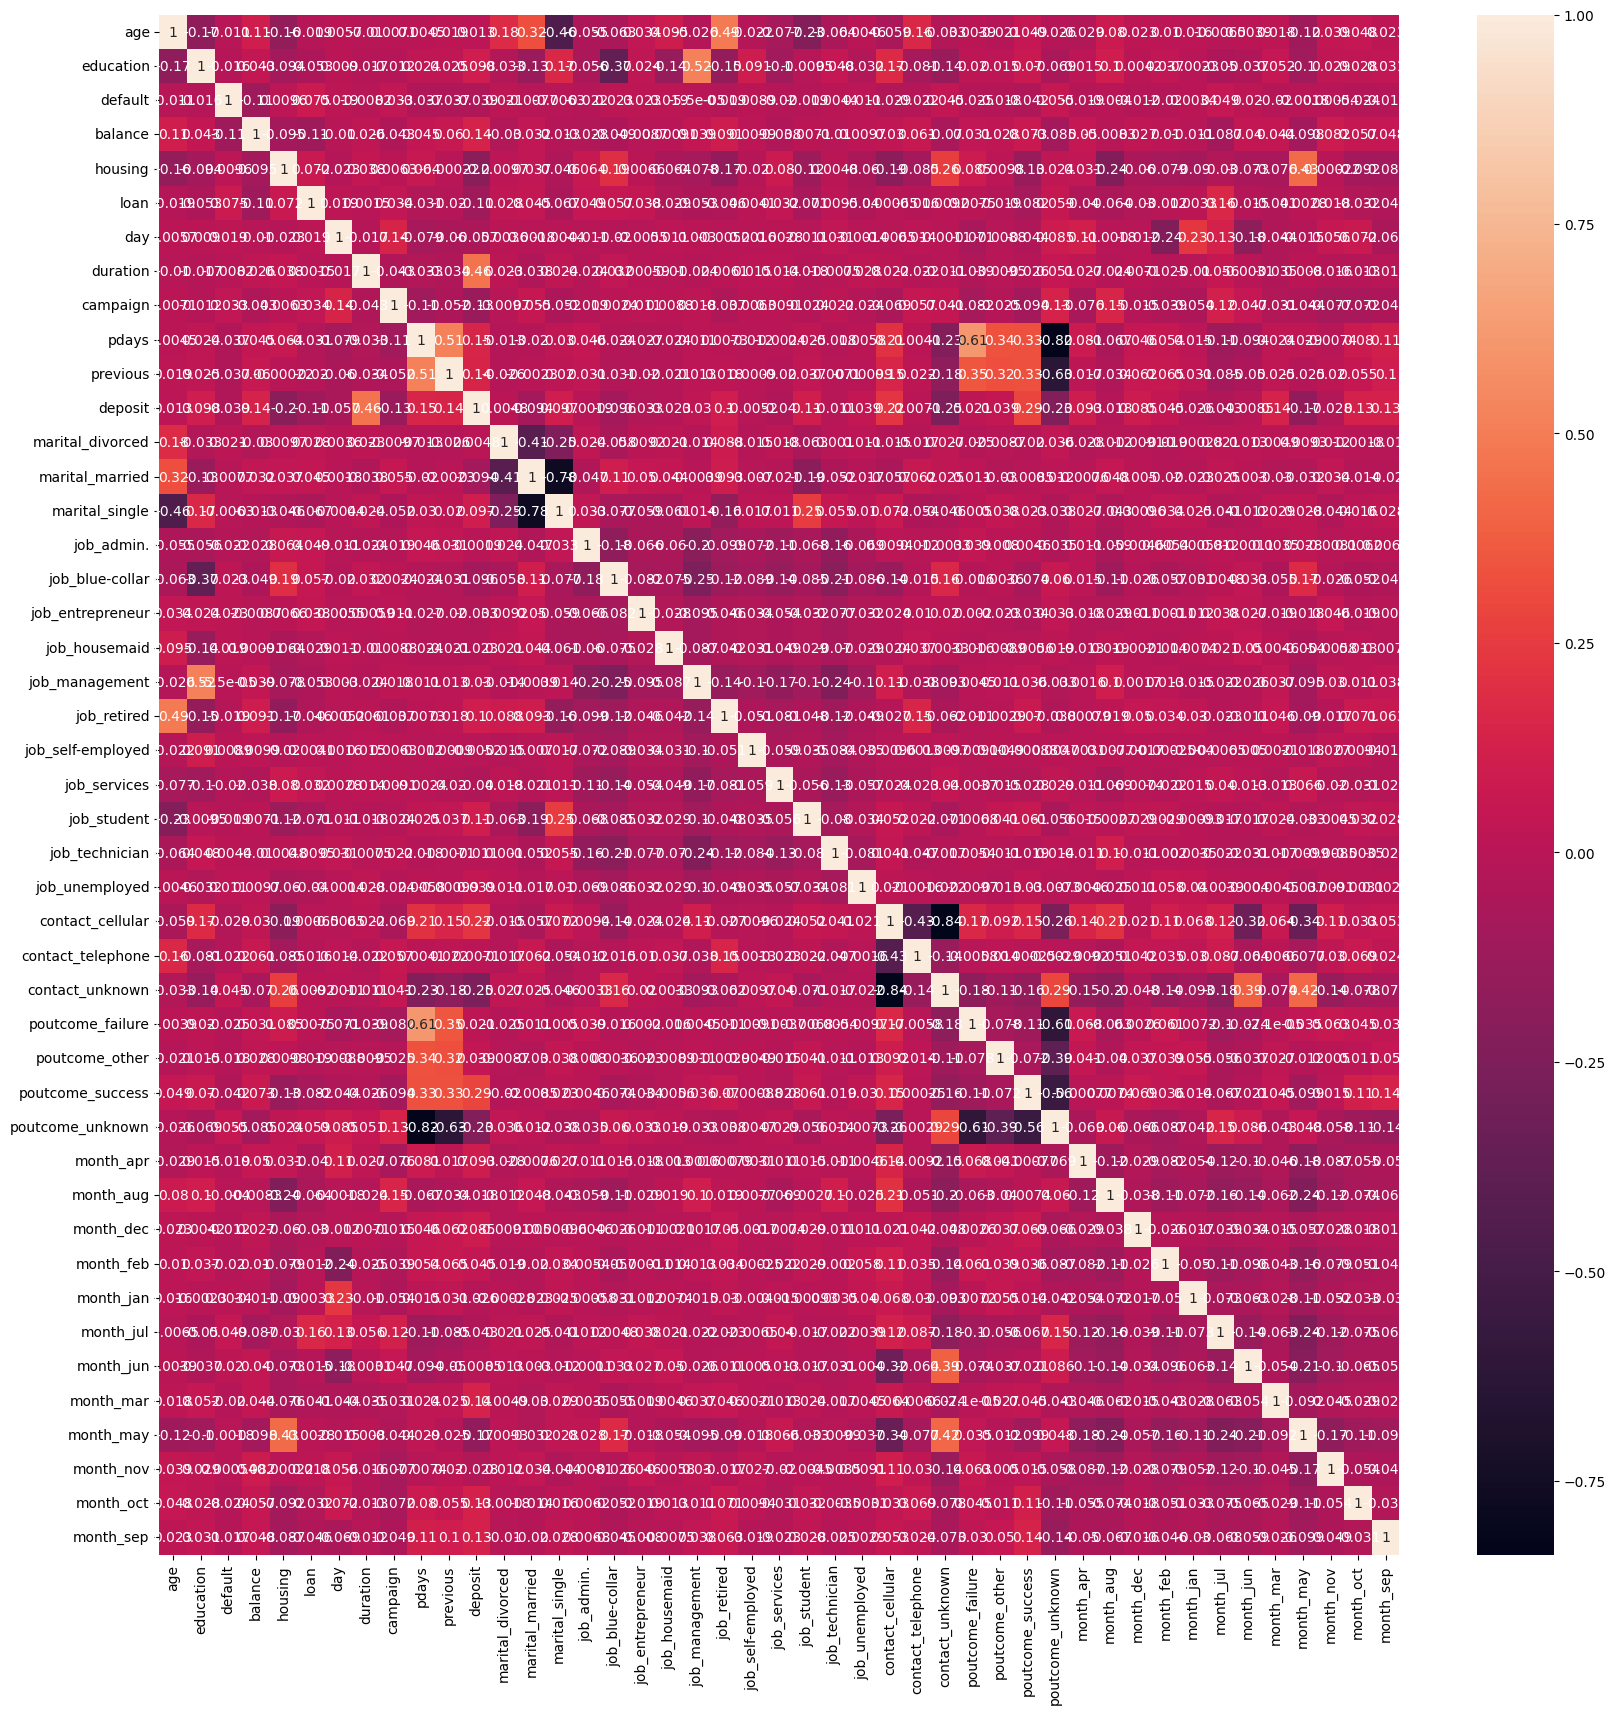

In [80]:
# построение корреляционной матрицы и оценка данных на предмет наличия мультиколлинеарности

plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(ds_5.corr(), annot=True)

<AxesSubplot:>

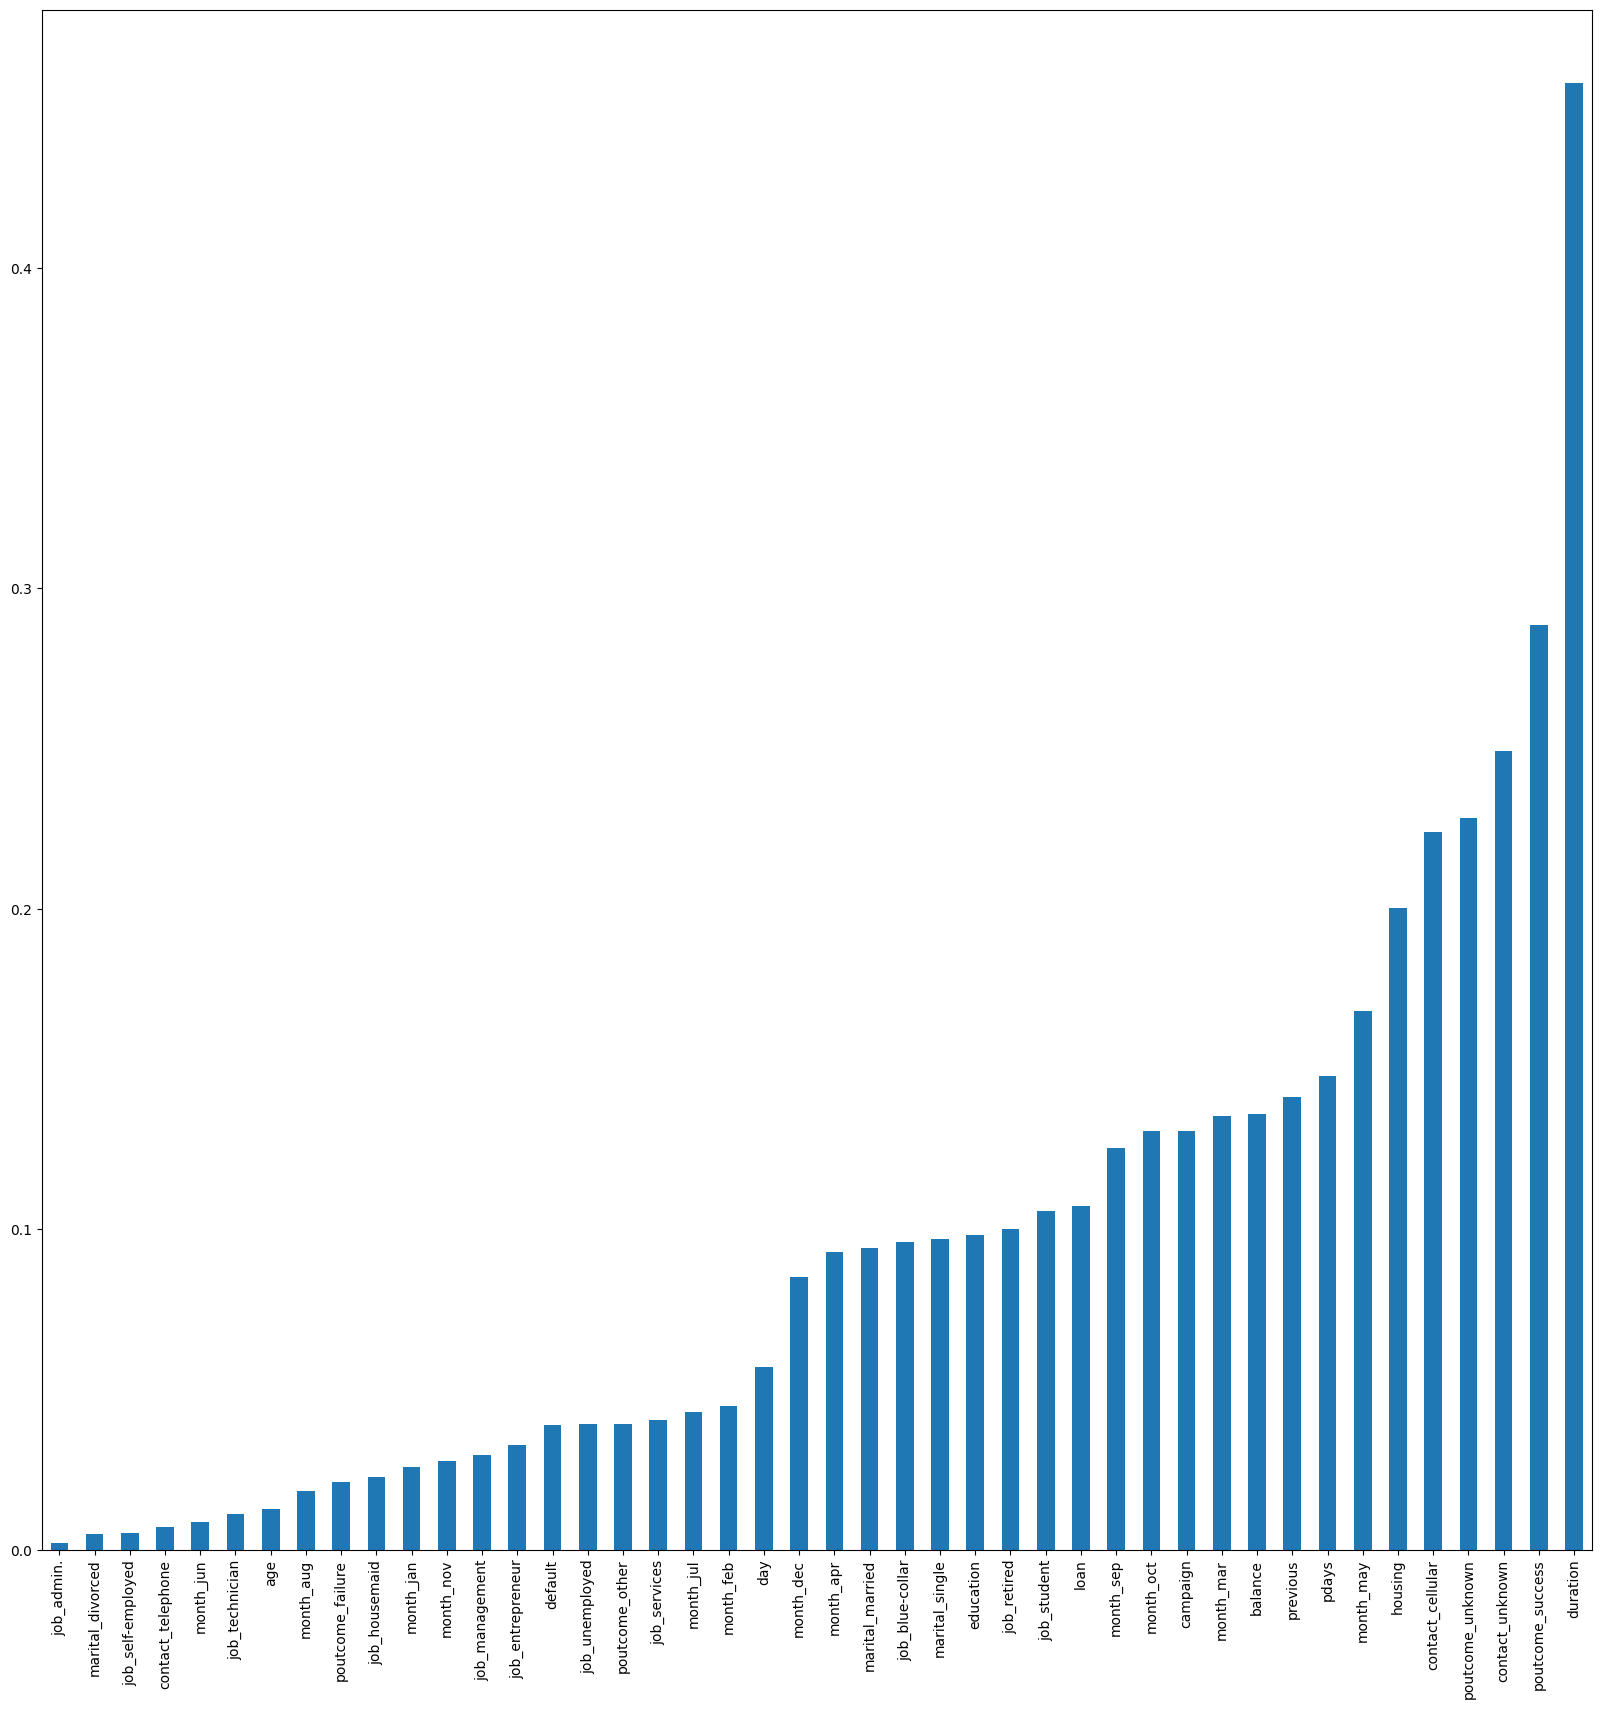

In [81]:
#оценка влияния переменных на результат
#Вычисляем модуль корреляции
corr_with_target = ds_5.corr()['deposit'].abs().sort_values()
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('deposit')
#Строим столбчатую диаграмму корреляций
corr_with_target.plot(kind='bar')

In [82]:
# создание выборок для обучения моделей

X = ds_5.drop(['deposit'], axis=1)
y = ds_5['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [83]:
X.shape, X_train.shape, X_test.shape

((10105, 44), (6770, 44), (3335, 44))

In [84]:
y_test.mean()

0.46326836581709147

In [85]:
from sklearn.preprocessing import MinMaxScaler

In [86]:
# с помощью SelectKBest отбор 15 наиболее подходящих признаков

skb = SelectKBest(score_func=f_classif, k=15)
skb.fit(X_train, y_train)
skb.get_feature_names_out()

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown',
       'poutcome_success', 'poutcome_unknown', 'month_mar', 'month_may',
       'month_oct', 'month_sep'], dtype=object)

In [87]:
main_feat = ['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown',
       'poutcome_success', 'poutcome_unknown', 'month_mar', 'month_may',
       'month_oct', 'month_sep', 'deposit']

df = ds_5[main_feat]
df

,balance,housing,loan,duration,campaign,pdays,previous,contact_cellular,contact_unknown,poutcome_success,poutcome_unknown,month_mar,month_may,month_oct,month_sep,deposit
0,2343.0,1,0,1042,1,-1,0,0,1,0,1,0,1,0,0,1
1,45.0,0,0,1467,1,-1,0,0,1,0,1,0,1,0,0,1
2,1270.0,1,0,1389,1,-1,0,0,1,0,1,0,1,0,0,1
3,2476.0,1,0,579,1,-1,0,0,1,0,1,0,1,0,0,1
4,184.0,0,0,673,2,-1,0,0,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,1.0,1,0,257,1,-1,0,1,0,0,1,0,0,0,0,0
11158,733.0,0,0,83,4,-1,0,0,1,0,1,0,0,0,0,0
11159,29.0,0,0,156,2,-1,0,1,0,0,1,0,0,0,0,0
11160,0.0,0,1,9,2,172,5,1,0,0,0,0,1,0,0,0


In [88]:
# создание набора данных для обучения из 15 выбранных факторов

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [89]:
#масштабирование данных

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled[:, 0].mean())

0.46823674223097866


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

In [90]:
# обучение логистической регрессии и рассчет метрики качества

#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(solver='sag', max_iter = 1000, random_state=42)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
y_train_pred = log_reg.predict(X_train_scaled)
print('accuracy_score на тренировочном наборе: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = log_reg.predict(X_test_scaled)
print('accuracy_scoreна тестовом наборе: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

accuracy_score на тренировочном наборе: 0.821
accuracy_scoreна тестовом наборе: 0.804


In [91]:
from sklearn.ensemble import RandomForestRegressor

In [92]:
# обучение решающих деревьев, настройка максимальной глубины

In [93]:
#Создаем объект класса дерево решений
dt = ensemble.RandomForestClassifier(random_state=42, criterion = 'entropy', max_depth=6)
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
print('accuracy_score на тренировочном наборе: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test_scaled)
print('accuracy_score на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

accuracy_score на тренировочном наборе: 0.83
accuracy_score на тестовом наборе: 0.82


In [94]:
# подбор оптимальных параметров с помощью gridsearch

from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_leaf': [2, 5, 7, 10],
              'max_depth': [3, 5, 7],
              'criterion':['entropy','gini']
              }
            
grid_search_tree = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid = param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_tree.predict(X_train_scaled)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: user 523 ms, sys: 62.7 ms, total: 586 ms
Wall time: 10.4 s
f1_score на тренировочном наборе: 0.83
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

In [95]:
# обучение на полученных данных модели случайный лес

#Создаем объект класса дерево решений
rf = ensemble.RandomForestClassifier(random_state=42, n_estimators=100, criterion = 'gini', max_depth=10, min_samples_leaf = 2)
#Обучаем дерево по алгоритму CARTrint
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('accuracy_score на тренировочном наборе: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('accuracy_score на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('recall_score на тестовом наборе: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

accuracy_score на тренировочном наборе: 0.86
accuracy_score на тестовом наборе: 0.83
recall_score на тестовом наборе: 0.84


In [96]:
# градиентный бустинг для классификации  для сравнения со случайным лесом

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
	max_depth = 5, #максимальная глубина дерева
    random_state = 42 #генератор случайных чисел
)
gb.fit(X_train_scaled, y_train)
 
y_train_pred  = gb.predict(X_train_scaled)

#Выводим значения метрики 
y_train_pred = gb.predict(X_train_scaled)
print('accuracy_score на тренировочном наборе: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = gb.predict(X_test_scaled)
print('accuracy_score на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('recall_score на тестовом наборе: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy_score на тренировочном наборе: 0.88
accuracy_score на тестовом наборе: 0.82
recall_score на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.81


In [97]:
# объединение уже известных алгоритмов с помощью стекинга 

from sklearn import linear_model #линейные моделиё
from sklearn.ensemble import StackingClassifier

#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('gb', GradientBoostingClassifier(learning_rate = 0.05,
                                        n_estimators = 300,
                                        min_samples_leaf = 5,
	                                    max_depth = 5,
                                        random_state = 42)),
    ('rf',  ensemble.RandomForestClassifier(random_state=42, 
                                            n_estimators=100, 
                                            criterion = 'gini', 
                                            max_depth=10, 
                                            min_samples_leaf = 2)),
    ('lr', linear_model.LogisticRegression(solver='sag', 
                                           max_iter = 1000, 
                                           random_state=42))
]

In [98]:
#Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
 
#Обучаем модель
reg.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42)),
                               ('rf',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_leaf=2,
                                                       random_state=42)),
                               ('lr',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag'))],
                   final_estimator=LogisticRegression(random_state=42))

In [99]:
y_train_pred = reg.predict(X_train_scaled)
print('accuracy_score на тренировочном наборе: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = reg.predict(X_test_scaled)
print('accuracy_score на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('recall_score на тестовом наборе: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('precision_score на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))

accuracy_score на тренировочном наборе: 0.86
accuracy_score на тестовом наборе: 0.83
recall_score на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.82
precision_score на тестовом наборе: 0.81


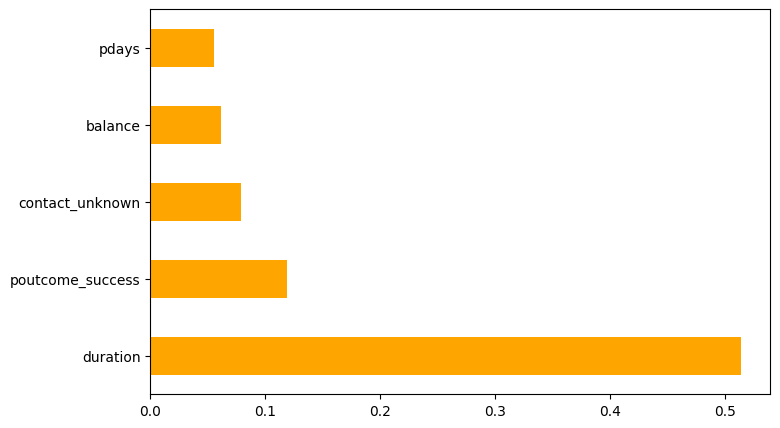

In [100]:
# оценка, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

plt.rcParams['figure.figsize'] = (8,5)
feat_importances = pd.Series(gb.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh', color='orange');

In [101]:
# реализация оптимизации гиперпараметров с помощью Optuna

In [102]:
import optuna

random_state = 42

In [103]:
# задаём параметры кросс-валидации (стратифицированная, 5-фолдов, с перемешиванием)
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [104]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))
  
  # применим  cross validation с тем же количеством фолдов
  score = cross_val_score(model, X, y, cv=skf, scoring="f1", n_jobs=-1).mean()

  return score

In [105]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)

[I 2022-09-28 22:36:42,443] A new study created in memory with name: RandomForestClassifier
[I 2022-09-28 22:36:45,152] Trial 0 finished with value: 0.8226393246161429 and parameters: {'n_estimators': 164, 'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8226393246161429.
[I 2022-09-28 22:36:47,706] Trial 1 finished with value: 0.8173804645508765 and parameters: {'n_estimators': 152, 'max_depth': 22, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8226393246161429.
[I 2022-09-28 22:36:49,505] Trial 2 finished with value: 0.8228735725678007 and parameters: {'n_estimators': 106, 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8228735725678007.
[I 2022-09-28 22:36:51,733] Trial 3 finished with value: 0.817852416257238 and parameters: {'n_estimators': 147, 'max_depth': 25, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.8228735725678007.
[I 2022-09-28 22:36:53,314] Trial 4 finished with value: 0.8185524859594381 and parameters: {'n_e

CPU times: user 21.7 s, sys: 75.4 ms, total: 21.8 s
Wall time: 1min 10s


In [106]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('accuracy_score на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.87
f1_score на тестовом наборе: 0.82
accuracy_score на тестовом наборе: 0.83
